## Imports to determine functionality

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
 
import seaborn as sns

import nltk
from nltk.util import ngrams
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer
from bs4 import BeautifulSoup

import collections
from collections import Counter

import wordcloud
from wordcloud import WordCloud, STOPWORDS

from os import path
from re import sub
from re import compile
from email import message_from_file
from glob import glob

In [2]:
ham_dir = path.join('data', 'ham')
spam_dir = path.join('data', 'spam')

print('hams:', len(glob(f'{ham_dir}/*')))  # hams: 6952
print('spams:', len(glob(f'{spam_dir}/*')))  # spams: 2399

hams: 6952
spams: 2399


## Define Classes

In [3]:
class StandardEmail:
    def __init__(self, subject: str, body: str, origin: str, destination: str):
        self.destination = destination
        self.origin = origin
        self.subject = subject
        self.body = body

    @property
    def clean(self):
        sanitizer = '[^A-Za-z]+'
        clean = sub(sanitizer, ' ', f'{self.subject} {self.body} {self.origin} {self.destination}')
        clean = clean.lower()
        return sub('\s+', ' ', clean)

    @property
    def structured_clean(self):
        sanitizer = '[^A-Za-z]+'
        newsanitizer = compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
        
        subject = sub(newsanitizer, ' ', f'{self.subject}').lower().lstrip()
        body = sub(sanitizer, ' ', f'{self.body}').lower().lstrip()
        origin = sub(sanitizer, ' ', f'{self.origin}').lower().lstrip()
        destination = sub(sanitizer, ' ', f'{self.destination}').lower().lstrip()
        
        bsubject = BeautifulSoup(f'{self.subject}', "lxml").text.lower().lstrip()
        bbody = BeautifulSoup(f'{self.body}', "lxml").text.lower().lstrip()
        borigin = BeautifulSoup(f'{self.origin}', "lxml").text.lower().lstrip()
        bdestination = BeautifulSoup(f'{self.destination}', "lxml").text.lower().lstrip()
        
        # use regular expressions
        # return [sub('\s+', ' ', origin), sub('\s+', ' ', destination), sub('\s+', ' ', subject), sub('\s+', ' ', body)]
        
        # use beautiful soup to clean https
        return [sub('\s+', ' ', borigin), sub('\s+', ' ', bdestination), sub('\s+', ' ', bsubject), sub('\s+', ' ', bbody)]

    def __str__(self):
        subject = f'subject: {self.subject}'
        body_first_line = self.body.split('\n')[0]
        body = f'body: {body_first_line}...'
        return f'{subject}\n{body}'

    def __repr__(self):
        return self.__str__()

In [4]:
class EmailIterator:
    def __init__(self, directory: str):
        self._files = glob(f'{directory}/*')
        self._pos = 0

    def __iter__(self):
        self._pos = -1
        return self

    def __next__(self):
        if self._pos < len(self._files) - 1:
            self._pos += 1
            return self.parse_email(self._files[self._pos])
        raise StopIteration()

    @staticmethod
    def parse_email(filename: str) -> StandardEmail:
        with open(filename,
                  encoding='utf-8',
                  errors='replace') as fp:
            message = message_from_file(fp)

        subject = None
        for item in message.keys():
            if item == 'Subject':
                subject = message[item]

        if message.is_multipart():
            body = []
            for b in message.get_payload():
                body.append(str(b))
            body = '\n'.join(body)
        else:
            body = message.get_payload()

        return StandardEmail(subject, body, message["From"], message["To"])

## Load emails into memory

In [5]:
ham_emails = EmailIterator('data/ham')
spam_emails = EmailIterator('data/spam')

## Load List of Emails

In [6]:
print("Loading Ham Emails into Memory Please Wait...")
hams = [email.structured_clean for email in ham_emails]
#hams = [[email.destination, email.origin, email.subject, email.body] for email in ham_emails]

Loading Ham Emails into Memory Please Wait...


C:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "http://www.post-gazette.com/columnists/20020905brian5.asp



" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "http://apt.nixia.no/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


In [7]:
print("Loading Spam Emails into memory Please Wait...")
spams = [email.structured_clean for email in spam_emails]

Loading Spam Emails into memory Please Wait...


C:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "http://www.efi.ie/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "http://www.efi.ie" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "http://iiu.taint.org" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Sou

In [8]:
Ham_Subject = []
Ham_Body = []
Ham_From = []
Ham_To = []
for item in hams:
    Ham_From.append(item[0])
    Ham_To.append(item[1])
    Ham_Subject.append(item[2])
    Ham_Body.append(item[3])
    
Ham_Dictionary = {"From":Ham_From, "To":Ham_To, "Subject":Ham_Subject, "Body":Ham_Body}
Ham_DataFrame = pd.DataFrame(Ham_Dictionary)
Ham_DataFrame #illustrate hamframe in interactive notebook

,From,To,Subject,Body
0,robert elz,chris garrigues,re: new sequences window,"date: tue, 20 aug 2002 17:27:47 -0500 from: ch..."
1,robert elz,chris garrigues,re: new sequences window,"date: wed, 21 aug 2002 10:54:46 -0500 from: ch..."
2,the motley fool,mkettler@home.com,personal finance: resolutions you can keep,======================== the motley fool =====...
3,chris garrigues,valdis.kletnieks@vt.edu,re: new sequences window,content-type: text/plain; charset=us-ascii > f...
4,steve burt,"""'zzzzteana@yahoogroups.com'""",[zzzzteana] re: alexander,"martin a posted: tassos papadopoulos, the gree..."
...,...,...,...,...
6947,guardian,yyyy@example.com,go-ahead for new-style hospitals,"url: http://www.newsisfree.com/click/-4,872399..."
6948,newscientist,yyyy@example.com,malicious code hidden in email software,"url: http://www.newsisfree.com/click/-3,871080..."
6949,guardian,yyyy@example.com,'flexible' retirement gains ground,"url: http://www.newsisfree.com/click/-4,872400..."
6950,newscientist,yyyy@example.com,critical us satellites could be hacked,"url: http://www.newsisfree.com/click/-3,870882..."


In [9]:
Spam_Subject = []
Spam_Body = []
Spam_From = []
Spam_To = []
for item in spams:
    Spam_From.append(item[0])
    Spam_To.append(item[1])
    Spam_Subject.append(item[2])
    Spam_Body.append(item[3])
    
Spam_Dictionary = {"From":Spam_From, "To":Spam_To, "Subject":Spam_Subject, "Body":Spam_Body}
Spam_DataFrame = pd.DataFrame(Spam_Dictionary)
Spam_DataFrame #illustrate spamframe in interactive notebook

,From,To,Subject,Body
0,none,none,none,mv 1 00001.bfc8d64d12b325ff385cca8d07b84288 mv...
1,"""start now""",ilug@linux.ie,[ilug] stop the mlm insanity,greetings! you are receiving this letter becau...
2,12a1mailbot1@web.de,,life insurance - why pay more?,<= /tr> save up to 70% on life insurance. why ...
3,lmrn@mailexcite.com,ranmoore@cybertime.net,"real protection, stun guns! free shipping! tim...","the need for safety is real in 2002, you might..."
4,"""slim down""",,[ilug] guaranteed to lose 10-12 lbs in 30 days...,1) fight the risk of cancer! http://www.adclic...
...,...,...,...,...
2394,"""iq - cna""",,hit the road with cna,"content-type: text/plain; charset=""windows-125..."
2395,answer.us@davicom.co.kr,undisclosed-recipients:;,$10 a hour for watching e-mmercials! no joke!,answer-us unlist information this message is b...
2396,beautyinfufuxxxmeb13mxy@aol.com,,make a fortune on ebay 24772,"""ebay - #1 rated work a= t home business oppor..."
2397,"""about time""",,faeries,uncommon exotic pleasure botanicals! feeling m...


# ▚▚ Exploratory Data Analysis ▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚▚

In [10]:
## Subject Character Length

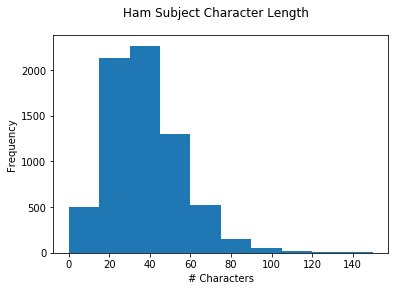

In [11]:
hamhist = Ham_DataFrame["Subject"].str.len().plot(kind='hist',subplots=True,sharex=True,sharey=True,title='Ham Subject Character Length', range=[0, 150])
for ax in hamhist.flatten():
    ax.set_xlabel("# Characters")
    ax.set_ylabel("Frequency")

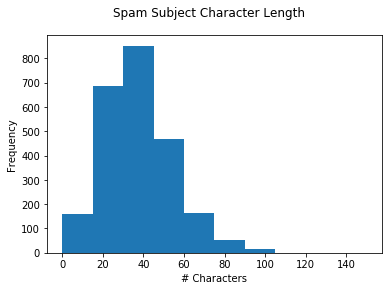

In [12]:
spamhist = Spam_DataFrame["Subject"].str.len().plot(kind='hist',subplots=True,sharex=True,sharey=True,title='Spam Subject Character Length', range=[0, 150])
for ax in spamhist.flatten():
    ax.set_xlabel("# Characters")
    ax.set_ylabel("Frequency")

## Top Non Stopwords in Body Text //Useless

In [13]:
#### Stopwords Function (with modifications) from https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools

In [14]:
def plot_top_non_stopwords_barchart(text):
    
    extrawords = [">", "-", "—", "face", "nbsp","arial","center","align", "http", "com", "td", "width", "www", "font", "height", "src", "img", "gif", "href", "border", "table", "size", "chart", "bgcolor", "color", "cnet"]
    
    stopwords = nltk.corpus.stopwords.words('english')
    stopwords.extend(extrawords)
    stop=set(stopwords)
    
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:40]:
        if (word not in stop):
            x.append(word)
            y.append(count)
            
    sns.barplot(x=y,y=x)

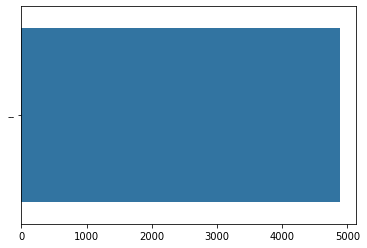

In [15]:
plot_top_non_stopwords_barchart(Ham_DataFrame['Body'])

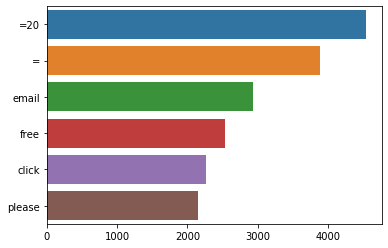

In [16]:
plot_top_non_stopwords_barchart(Spam_DataFrame['Body'])

## Word Length (Average)

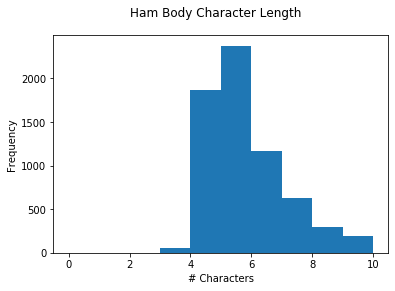

In [17]:
hwordlen = Ham_DataFrame["Body"].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).plot(kind='hist',subplots=True,sharex=True,sharey=True,title='Ham Body Character Length', range=[0, 10])
for ax in hwordlen.flatten():
    ax.set_xlabel("# Characters")
    ax.set_ylabel("Frequency")

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


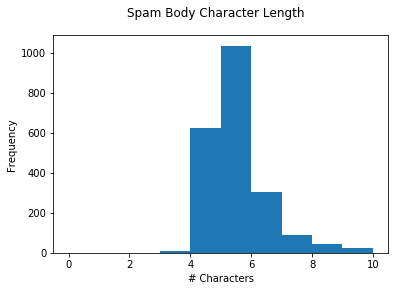

In [18]:
swordlen = Spam_DataFrame["Body"].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).plot(kind='hist',subplots=True,sharex=True,sharey=True,title='Spam Body Character Length', range=[0, 10])
for ax in swordlen.flatten():
    ax.set_xlabel("# Characters")
    ax.set_ylabel("Frequency")


## Word Clouds

In [19]:
#### word clouds funcntion (with modifications) from https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools

In [20]:
def plot_wordcloud(text):
    
    extrawords = [">", "-", "—", "face", "nbsp","arial","center","align", "http", "com", "td", "width", "www", "font", "height", "src", "img", "gif", "href", "border", "table", "size", "chart", "bgcolor", "color", "cnet"]
    stopwords = nltk.corpus.stopwords.words('english')
    stopwords.extend(extrawords)
    stop=set(stopwords)

    def _preprocess_text(text):
        corpus=[]
        stem=PorterStemmer()
        lem=WordNetLemmatizer()
        for news in text:
            words=[w for w in word_tokenize(news) if (w not in stop)]

            words=[lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)
        return corpus
    
    corpus=_preprocess_text(text)
    
    wordcloud = WordCloud(
        background_color='white',
        stopwords=set(STOPWORDS),
        max_words=100,
        max_font_size=30, 
        scale=3,
        random_state=1)
    
    wordcloud=wordcloud.generate(str(corpus))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
 
    plt.imshow(wordcloud)
    plt.show()



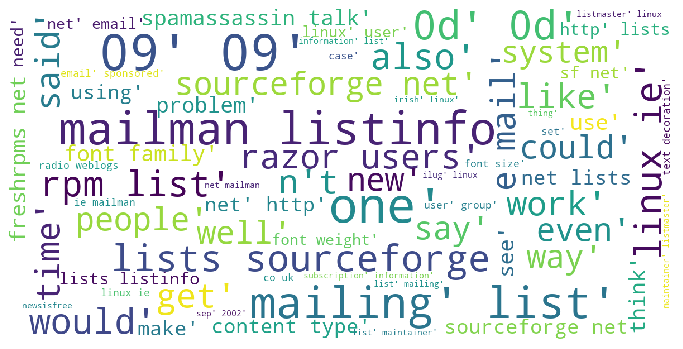

In [21]:
plot_wordcloud(Ham_DataFrame["Body"])

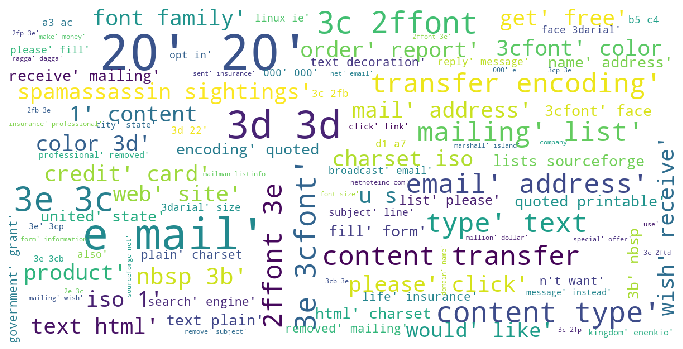

In [22]:
plot_wordcloud(Spam_DataFrame["Body"])

## Top Bigrams in Body Text //Useless

In [23]:
#### Top Bigrams Function from https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools

In [24]:
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

[Text(0.5, 1.0, 'Bigram Frequencey (Ham)')]

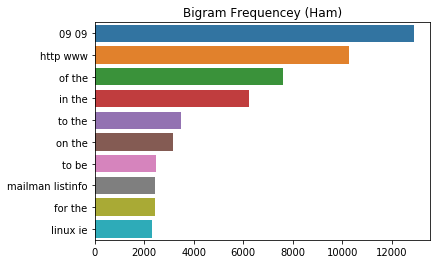

In [25]:
top_n_bigrams = get_top_ngram(Ham_DataFrame["Body"], 2)[:10]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x).set(title='Bigram Frequencey (Ham)')


[Text(0.5, 1.0, 'Bigram Frequencey (Spam)')]

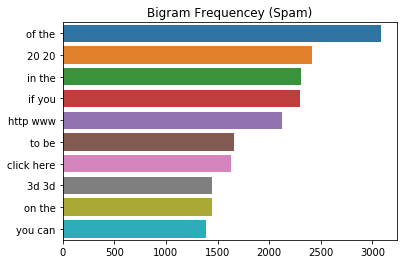

In [26]:
top_n_bigrams = get_top_ngram(Spam_DataFrame["Body"], 2)[:10]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x).set(title='Bigram Frequencey (Spam)')